Thomas Conibear - Project Two Code of vpython Simulation and Entropy Code

For simulation to run properly it should be opened up in a local host url. I accomplished this using the anaconda prompt. 

In [ ]:
#Vpython simulation
from vpython import *
import time
import numpy as np

scene.height = scene.width = 640
scene.background = color.white
scene.autoscale = False

win = 500

# Constants
L = 1 # Container is a rectangle with length L as its base
gray = color.yellow # Color of sides of container
mass = 4E-3/6E23 # Helium mass, scaled to work in simulation properly
Ratom = 0.03 # Radius of particles, incredibly large compared to actual value so it can be seen in simulation
k = 1.4E-23 # Boltzmann's constant
T = 300 # Temperature, near room temperature
dt = 1E-5

# Create box using vpython 
d = L/2+Ratom # Scale it to size of atoms so entire simulation can be seen
d2 = d * 2
r = 0.005
boxbottom = curve(color=gray, radius=r)
boxbottom.append([vector(-d2,-d,-d), vector(-d2,-d,d), vector(d2,-d,d), vector(d2,-d,-d), vector(-d2,-d,-d)])
boxtop = curve(color=gray, radius=r)
boxtop.append([vector(-d2,d,-d), vector(-d2,d,d), vector(d2,d,d), vector(d2,d,-d), vector(-d2,d,-d)])
vert1 = curve(color=gray, radius=r)
vert2 = curve(color=gray, radius=r)
vert3 = curve(color=gray, radius=r)
vert4 = curve(color=gray, radius=r)
vert1.append([vector(-d2,-d,-d), vector(-d2,d,-d)])
vert2.append([vector(-d2,-d,d), vector(-d2,d,d)])
vert3.append([vector(d2,-d,d), vector(d2,d,d)])
vert4.append([vector(d2,-d,-d), vector(d2,d,-d)])

div_width = 0.1
div_height = 1.2
div = box(pos=vector(0,0,0), size=vector(div_width,div_height,div_height),
            color=color.yellow, opacity=0.5)
div2 = box(pos=vector(0,0,0), size=vector(div_width,div_height,div_height),
            color=color.yellow, opacity=0.5)

pavg = sqrt(2*mass*1.5*k*T) # kinetic energy converted to p: p**2/(2mass) = (3/2)kT : average energy using equipartition theorem

#Uses class of functions to make up entire simulation

class GasSimulation:
    def __init__(self, particle_count):
        self.Atoms = []
        self.p = []
        self.apos = []
        self.Natoms = particle_count

        # Simulation boolean false/true for pause button
        self.paused = False
        self.running = True

        for i in range(self.Natoms):
            x = L*random()*2-L                          # random range to spawn in
            y = L*random()-L/2
            z = L*random()-L/2

            # Color of atoms based on position relative to divider
            if i == 0:
                self.Atoms.append(sphere(pos=vector(x,y,z), radius=Ratom, color=color.cyan, make_trail=True, retain=100, trail_radius=0.3*Ratom))
            else:
                if x < div.pos.x:
                    self.Atoms.append(sphere(pos=vector(x,y,z), radius=Ratom, color=color.blue))
                else:
                    self.Atoms.append(sphere(pos=vector(x,y,z), radius=Ratom, color=color.red))
            self.apos.append(vec(x,y,z))
           
            # Random initial momentum vector components. Phi and theta are spherical coordinates of the particle itself
            theta = pi*random()
            phi = 2*pi*random()
            px = pavg*sin(theta)*cos(phi)
            py = pavg*sin(theta)*sin(phi)
            pz = pavg*cos(theta)
            self.p.append(vector(px,py,pz))

    def Sackur_Tetrode_He(self, ZZTop, volume):
        if ZZTop == 0:
            return 0

        k = 1.381e-23
        #V = 0.001
        V = volume #done in case want different volume in entropy code further down
        h = 6.626e-34
        m = 6.646e-27
        T = 300
        U = ZZTop*3/2*k*T

        a = ZZTop*k
        b = ((4*pi*m*U)/(3*ZZTop*h**2))**3/2
        c = np.log(((V/ZZTop)*b))+5/2
        return a*c

    def get_entropy(self, atom_count, volume):
        return self.Sackur_Tetrode_He(atom_count, volume)

    def pause(self, button):
        self.paused = not self.paused
        button.text = "Play" if self.paused else "Pause"

    def cleanup(self):                       #Clears previous particles if reset simulation
        self.paused = True
        self.running = False
        for atom in self.Atoms:
            atom.clear_trail()
            atom.visible = False
            del atom
#Code used to detect collisions between particles but I did not use this for anything
    def checkCollisions(self):
        hitlist = []
        r2 = 2*Ratom
        r2 *= r2
        for i in range(self.Natoms):
            ai = self.apos[i]               # pos of first particle
            for j in range(i):
                aj = self.apos[j]           # pos of second particle
                dr = ai - aj                # Check distance between particles
                if mag2(dr) < r2:           # Check if spheres intersect as dr is less than diameter of particle
                    hitlist.append([i,j])
        return hitlist                      # return list of pairs of intersecting particles
    
#global variables for position and entropy graphs
    def run(self):
        global avg_graph 
        global avg_graph_blue
        global time_value
        global scene
        global d

        while self.running:
            if self.paused:
                continue
            rate(300)

            # Update all positions
            for i in range(self.Natoms):
                self.Atoms[i].pos = self.apos[i] = self.apos[i] + (self.p[i]/mass)*dt   # Move by p/m = v * dt = dx,dy,dz

            
            # average positions
            blue_total = 0
            blue_count = 0
            red_total = 0
            red_count = 0

            for i in range(self.Natoms):
                loc = self.apos[i] #New position variable here to avoid variable confusion in program
                
                # collide with divider
                if div.visible:                                                             # is divider enabled?
                    xdelta = loc.x - div.pos.x                                                  
                    if abs(xdelta) < div_width and abs(loc.y) > div.pos.y - div_height/2:   # is particle x inside divider and particle y outside aperture?
                        if xdelta < 0:                                                  # is particle to left of divider?
                            self.p[i].x = -abs(self.p[i].x)
                        else:                                               # otherwise particle is to right of divider
                            self.p[i].x = abs(self.p[i].x)

                # collide with outer walls
                if abs(loc.x) > L:                                                      # collide left/right walls
                    if loc.x < 0:      #If particle is on left of divider, it's momentum x-component is negative
                        self.p[i].x = abs(self.p[i].x)    #So it is made positive
                    else:
                        self.p[i].x = -abs(self.p[i].x)
                
                if abs(loc.y) > L/2:                                                # collide top/bottom walls
                    if loc.y < 0:
                        self.p[i].y = abs(self.p[i].y)
                    else:
                        self.p[i].y = -abs(self.p[i].y)
                
                if abs(loc.z) > L/2:                                                # collide front/back walls
                    if loc.z < 0:
                        self.p[i].z = abs(self.p[i].z)
                    else:
                        self.p[i].z = -abs(self.p[i].z)

                # average
                if self.Atoms[i].color == color.red:                                # accumulate positions for average
                    red_total += loc.x
                    red_count += 1
                else:
                    blue_total += loc.x
                    blue_count += 1

            # time
            time_value += dt

            # graph averages
            if red_count != 0 and blue_count != 0:                                              # prevent division by 0
                red_avg = red_total / red_count
                blue_avg = blue_total / blue_count
                avg_graph.plot(pos=(time_value, red_avg))
                avg_graph_blue.plot(pos=(time_value, blue_avg))

            # graph entropy

            # Get entropy for each color
            min_x = 0
            max_x = 0
            
            # blue
            for i in range(self.Natoms):
                if self.Atoms[i].color == color.blue:
                    if self.Atoms[i].pos.x < min_x:
                        min_x = self.Atoms[i].pos.x
            for i in range(self.Natoms):
                if self.Atoms[i].color == color.blue:
                    if self.Atoms[i].pos.x > max_x:
                        max_x = self.Atoms[i].pos.x
            volume_blue = (max_x - min_x) * d * d                          # In case you want dynamic volume of gas cloud
            entropy_blue = self.get_entropy(blue_count, 0.001)             # Calculate with total volume of box

            # red
            for i in range(self.Natoms):
                if self.Atoms[i].color == color.red:
                    if self.Atoms[i].pos.x < min_x:
                        min_x = self.Atoms[i].pos.x
            for i in range(self.Natoms):
                if self.Atoms[i].color == color.red:
                    if self.Atoms[i].pos.x > max_x:
                        max_x = self.Atoms[i].pos.x
            volume_red = (max_x - min_x) * d * d
            entropy_red = self.get_entropy(red_count, 0.001)

            entropy_graph.plot(pos=(time_value, entropy_red))
            entropy_graph_blue.plot(pos=(time_value, entropy_blue))
            print(red_count, entropy_red, blue_count, entropy_blue, blue_count + red_count, entropy_red + entropy_blue)


scene.append_to_caption('\n')

deltav = 100

### Sliders and controls

def reset():
    global simulation
    global deltav
    global nhisto
    global histo
    global accum
    global vdist
    global time_value
    global avg_graph
    global avg_graph_blue

    # clear graphs
    avg_graph.delete()
    avg_graph_blue.delete()
    entropy_graph.delete()
    entropy_graph_blue.delete()

    simulation.cleanup()                                                 # delete old vpython objects
    del simulation                                                       # delete the simulation
    
    time.sleep(1)                                                        # wait so new particles aren't affected by old

    simulation = GasSimulation(num_particles)                            # create and run new simulation
    simulation.run()
button(text="Reset", bind=reset)

def pause():
    global pause_button
    global simulation
    simulation.pause(pause_button)
pause_button = button(text="Pause", bind=pause)

def toggle_dividers():
    div.visible = not div.visible
    div2.visible = not div2.visible
button(text="Toggle Divider", bind=toggle_dividers)
scene.append_to_caption('\n')

num_particles = 0
def set_num_particles(n):
    global num_particles
    num_particles = int(n.value)
scene.append_to_caption('Number of Particles: ')
slider(text="Number of Particles: ", min=1, max=1000, value=1, bind=set_num_particles)
scene.append_to_caption('\n')

def move_dividers(y):
    div.pos = vector(div.pos.x, y.value, 0)
    div2.pos = vector(div2.pos.x, -y.value, 0)
scene.append_to_caption('Divider Aperture: ')
slider(text="Move Slider", min=0, max=div_height, value = 0.0, bind=move_dividers)
scene.append_to_caption('\n')

def move_divider_x(x):
    div.pos = vector(x.value, div.pos.y, 0)
    div2.pos = vector(x.value, div2.pos.y, 0)
scene.append_to_caption('Divider x: ')
slider(text="Move Slider", min=-d2, max=d2, value = 0.0, bind=move_divider_x)
scene.append_to_caption('\n\n')

# Atoms
atom_count = 5

# Time
time_value = 0

# Average position graph
avg_plot = graph(title='Avg. Position: Red v. Blue', xtitle='time', ytitle='X Position', fast=False, width=800)
avg_graph = gcurve(color=color.red)
avg_graph_blue = gcurve(color=color.blue)

# Entropy graph
entropy_plot = graph(title='Entropy: Red v. Blue', xtitle='time', ytitle='Entropy', fast=False, width=800)
entropy_graph = gcurve(color=color.red)
entropy_graph_blue = gcurve(color=color.blue)

# Start
simulation = GasSimulation(atom_count)
simulation.run()

In [1]:
#Entropy code
import numpy as np
from math import pi


Values_He = []


def Sackur_Tetrode_He(N1):
    k = 1.381e-23 #Boltzmann's Constant
    V = 0.5*0.001 #Volume in m**3
    h = 6.626e-34 #Planck's Constant
    m = 6.646e-27 #Mass of Helium
    T = 300       #Temperature in Kelvins
    U = N1*3/2*k*T #Internal Energy using Equipartition Theorem
    
    a = N1*k
    b = ((4*pi*m*U)/(3*N1*h**2))**3/2
    c = np.log(((V/N1)*b))+5/2
    return a*c

Particle_Range_He = range(1, 1000, 1)

for N1 in Particle_Range_He:
    Values_He.append(Sackur_Tetrode_He(N1))
        
Values_Ar = []

def Sackur_Tetrode_Ar(N2):
    k = 1.381e-23
    V = 0.5*0.001
    h = 6.626e-34
    m = 6.633e-26
    T = 300
    U = N2*3/2*k*T
    
    a = N2*k
    b = ((4*pi*m*U)/(3*N2*h**2))**3/2
    c = np.log(((V/N2)*b))+5/2
    return a*c

Particle_Range_Ar = range(1, 1000, 1)

for N2 in Particle_Range_Ar:
    Values_Ar.append(Sackur_Tetrode_Ar(N2))

S_Unmixed = np.add(Values_He, Values_Ar)


Values_Mixing = []

def Entropy_Mixing(N):
    k = 1.381e-23
    return 2*N*k*np.log(2)

Particle_Range_Mixing = range(1, 1000, 1)

for N in Particle_Range_Mixing:
    Values_Mixing.append(Entropy_Mixing(N))


S_Total_Mixed = np.add(S_Unmixed, Values_Mixing)#.tolist() to convert array to list



In [2]:
from collections import OrderedDict
import pandas as pd

Entropy_Values = OrderedDict({'Number of Particles' : Particle_Range_Mixing,
             'Entropy Unmixed': S_Unmixed,
             'Entropy Mixed': S_Total_Mixed})

table = pd.DataFrame(Entropy_Values)
table

,Number of Particles,Entropy Unmixed,Entropy Mixed
0,1,3.864754e-21,3.883899e-21
1,2,7.691219e-21,7.729508e-21
2,3,1.150323e-20,1.156067e-20
3,4,1.530586e-20,1.538244e-20
4,5,1.910151e-20,1.919723e-20
5,6,2.289159e-20,2.300646e-20
6,7,2.667706e-20,2.681107e-20
7,8,3.045856e-20,3.061172e-20
8,9,3.423660e-20,3.440890e-20
9,10,3.801157e-20,3.820301e-20


In [28]:
Info = table.iloc[994]  
  
print(Info) 

Number of Particles    9.950000e+02
Entropy Unmixed        3.655730e-18
Entropy Mixed          3.674779e-18
Name: 994, dtype: float64


In [19]:
Sackur_Tetrode_He(100)

1.8211221469259303e-19

In [20]:
Sackur_Tetrode_Ar(100)

1.9164371282425885e-19

In [6]:
Entropy_Mixing(100)

1.914472512706569e-21

Text(0, 0.5, 'Total Mixed Entropy (J/K)')

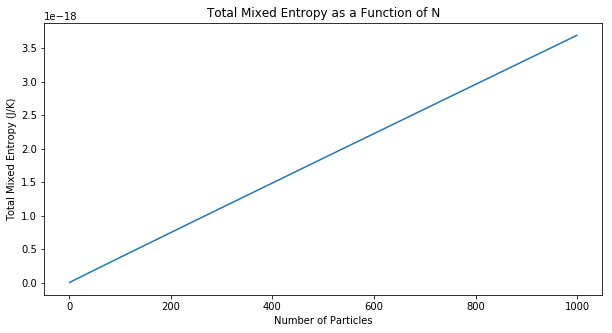

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))  
plt.plot(Particle_Range_He, S_Total_Mixed)
plt.title("Total Mixed Entropy as a Function of N")
plt.xlabel("Number of Particles")
plt.ylabel( "Total Mixed Entropy (J/K)")